# পিটার এবং নেকড়ে: বাস্তবসম্মত পরিবেশ

আমাদের পরিস্থিতিতে, পিটার প্রায় ক্লান্ত বা ক্ষুধার্ত না হয়েই চলাফেরা করতে পারত। কিন্তু একটি আরও বাস্তবসম্মত জগতে, তাকে মাঝে মাঝে বসে বিশ্রাম নিতে হবে এবং নিজেকে খাওয়াতে হবে। চলুন আমাদের জগৎটিকে আরও বাস্তবসম্মত করি, নিম্নলিখিত নিয়মগুলো প্রয়োগ করে:

1. এক জায়গা থেকে আরেক জায়গায় যাওয়ার সময়, পিটার **শক্তি** হারাবে এবং কিছু **ক্লান্তি** অর্জন করবে।
2. পিটার আপেল খেয়ে আরও শক্তি পেতে পারে।
3. পিটার গাছের নিচে বা ঘাসের উপর বিশ্রাম নিয়ে ক্লান্তি দূর করতে পারে (অর্থাৎ, এমন একটি বোর্ড লোকেশনে হাঁটা যেখানে গাছ বা ঘাস আছে - সবুজ ক্ষেত্র)।
4. পিটারকে নেকড়েকে খুঁজে বের করে হত্যা করতে হবে।
5. নেকড়েকে হত্যা করার জন্য, পিটারের নির্দিষ্ট মাত্রার শক্তি এবং ক্লান্তি থাকা প্রয়োজন, অন্যথায় সে যুদ্ধে হেরে যাবে।


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

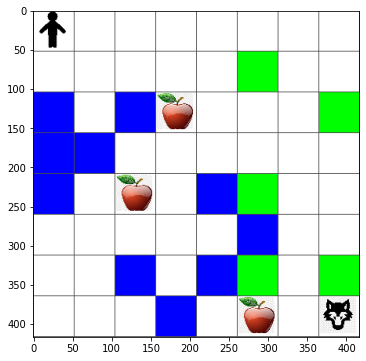

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## স্টেট সংজ্ঞায়িত করা

আমাদের নতুন গেমের নিয়মে, প্রতিটি বোর্ড স্টেটে শক্তি এবং ক্লান্তি ট্র্যাক করতে হবে। তাই আমরা একটি অবজেক্ট `state` তৈরি করব যা বর্তমান সমস্যার স্টেট সম্পর্কিত সমস্ত প্রয়োজনীয় তথ্য বহন করবে, যার মধ্যে বোর্ডের অবস্থা, শক্তি এবং ক্লান্তির বর্তমান স্তর, এবং টার্মিনাল স্টেটে থাকা অবস্থায় আমরা নেকড়েকে হারাতে পারি কিনা তা অন্তর্ভুক্ত থাকবে:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

চলুন র্যান্ডম ওয়াক ব্যবহার করে সমস্যাটি সমাধানের চেষ্টা করি এবং দেখি আমরা সফল হই কিনা:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## পুরস্কার ফাংশন

একটি পুরস্কার ফাংশন হল একটি পদ্ধতি যা এজেন্টের কর্মের জন্য একটি মান নির্ধারণ করে। এটি এজেন্টকে তার লক্ষ্য অর্জনের জন্য সঠিক সিদ্ধান্ত নিতে উৎসাহিত করে।

### কীভাবে এটি কাজ করে

পুরস্কার ফাংশন এজেন্টের পরিবেশ থেকে ইনপুট গ্রহণ করে এবং একটি সংখ্যা প্রদান করে যা এজেন্টের কর্মের গুণমান নির্দেশ করে। এই সংখ্যা এজেন্টের শেখার প্রক্রিয়ায় গুরুত্বপূর্ণ ভূমিকা পালন করে।

### উদাহরণ

নিম্নলিখিত উদাহরণটি একটি সাধারণ পুরস্কার ফাংশন দেখায়:

```python
def reward_function(state, action):
    if action == "move_forward" and state == "clear_path":
        return 10  # উচ্চ পুরস্কার
    elif action == "move_forward" and state == "obstacle_ahead":
        return -10  # শাস্তি
    else:
        return 0  # নিরপেক্ষ
```

### গুরুত্বপূর্ণ বিষয়

- [!NOTE] পুরস্কার ফাংশনটি এজেন্টের লক্ষ্য এবং পরিবেশের সাথে সামঞ্জস্যপূর্ণ হতে হবে।
- [!WARNING] ভুলভাবে ডিজাইন করা পুরস্কার ফাংশন এজেন্টকে অপ্রত্যাশিত আচরণ শেখাতে পারে।
- [!TIP] পুরস্কার ফাংশনটি সহজ এবং কার্যকর রাখার চেষ্টা করুন।
- [!IMPORTANT] পুরস্কার ফাংশনটি এজেন্টের শেখার গতি এবং দক্ষতার উপর সরাসরি প্রভাব ফেলে।
- [!CAUTION] পুরস্কার ফাংশনটি পরীক্ষা এবং পরিমার্জন করা প্রয়োজন যাতে এটি সঠিকভাবে কাজ করে।


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## কিউ-লার্নিং অ্যালগরিদম

আসল শেখার অ্যালগরিদম প্রায় অপরিবর্তিত থাকে, আমরা শুধু বোর্ড অবস্থানের পরিবর্তে `state` ব্যবহার করি।


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

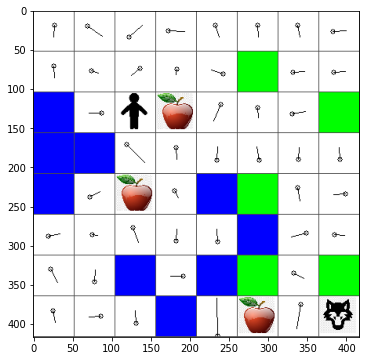

In [11]:
m.plot(Q)

## ফলাফল

চলুন দেখি আমরা পিটারকে নেকড়ের সাথে লড়াই করার জন্য প্রশিক্ষণ দিতে সফল হয়েছি কিনা!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


আমরা এখন ডুবে যাওয়ার ঘটনা অনেক কম দেখি, কিন্তু পিটার এখনও সবসময় নেকড়েকে মারতে সক্ষম হয় না। পরীক্ষা করে দেখুন এবং হাইপারপ্যারামিটার নিয়ে খেলে এই ফলাফল উন্নত করতে পারেন কিনা।


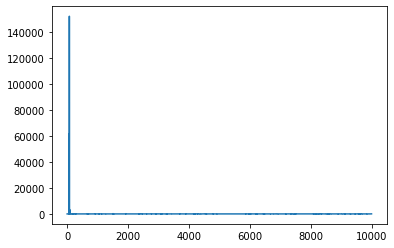

In [13]:
plt.plot(lpath)


---

**অস্বীকৃতি**:  
এই নথিটি AI অনুবাদ পরিষেবা [Co-op Translator](https://github.com/Azure/co-op-translator) ব্যবহার করে অনুবাদ করা হয়েছে। আমরা যথাসম্ভব সঠিক অনুবাদ প্রদানের চেষ্টা করি, তবে অনুগ্রহ করে মনে রাখবেন যে স্বয়ংক্রিয় অনুবাদে ত্রুটি বা অসঙ্গতি থাকতে পারে। মূল ভাষায় থাকা নথিটিকে প্রামাণিক উৎস হিসেবে বিবেচনা করা উচিত। গুরুত্বপূর্ণ তথ্যের জন্য, পেশাদার মানব অনুবাদ সুপারিশ করা হয়। এই অনুবাদ ব্যবহারের ফলে কোনো ভুল বোঝাবুঝি বা ভুল ব্যাখ্যা হলে আমরা তার জন্য দায়ী থাকব না।
